In [1]:
# import usual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# our system imports
from aideme import *

%matplotlib inline

In [2]:
def plot_fscore(metrics):
    df_list = [pd.DataFrame.from_dict({i: metric for i, metric in enumerate(ls)}, orient='index') for ls in metrics]
    avg = sum([df['fscore'][~df['fscore'].isna()] for df in df_list]) / len(df_list)
    avg.plot(ylim=[0,1], marker='o')
    plt.show()

In [3]:
# DUMMY DATA
N = int(1e5)
dim = 2
limit = 2 * (0.001)**(1. / dim)
rng = np.random.RandomState(0)
X = rng.uniform(low=-2, high=2, size=(N, dim))  # do not forget to standardize the data. For this distribution, it should be fine without it.
y_subspace = np.vstack([np.abs(X[:, i]) < limit for i in range(dim)]).T.astype('float')  # partial labels (for each subspace)
y = y_subspace.min(axis=1)

index = -10 * np.arange(len(X))
labeled_set = LabeledSet(y, y_subspace, index)

# visualize data distribution
print('selectivity :', 100 * y.sum() / len(y), '%')

#plt.figure(figsize=(10,8))
#plt.scatter(X[:, 0], X[:, 1], s=0.5, c=['b' if lb else 'r' for lb in y])
#plt.show()

selectivity : 0.105 %


# NO FACTORIZATION EXAMPLE

In [4]:
# SET-UP EXPLORATION CONFIGURATION
REPEAT = 1
NUMBER_OF_ITERATIONS = 100  # number of points to be labeled by the user

SUBSAMPLING = None

INITIAL_SAMPLER = stratified_sampler(labeled_set, pos=1, neg=1)  # start with one random positive sample and one random negative sample
#INITIAL_SAMPLER = random_sampler(10)

CALLBACK = [ # callback functions to be called at the end of each iteration
    classification_metrics(labeled_set.labels, ['fscore']), 
    three_set_metric,
]
CALLBACK_SKIP = 5
PRINT_CALLBACK_RESULT = True

CONVERGENCE_CRITERIA = [
    max_iter_reached(NUMBER_OF_ITERATIONS),
    #all_points_are_known,
    #metric_reached_threshold('fscore', 0.8),
    #metric_reached_threshold('tsm', 0.9),
]

SEED = list(range(REPEAT))

explore = PoolBasedExploration(INITIAL_SAMPLER, SUBSAMPLING, CALLBACK, CALLBACK_SKIP, PRINT_CALLBACK_RESULT, CONVERGENCE_CRITERIA)

# CHOOSE AN ALGORITHM
#learner = RandomSampler(SVC(C=1e5, kernel='rbf', gamma='auto'))  # choose a random point
#learner = SimpleMargin(C=1024, kernel='rbf')  # choose point closest to SVM decision boundary
#learner = DualSpaceModel(learner, sample_unknown_proba=0.5, mode='positive')  # Dual Space model

#learner = KernelQueryByCommittee(sampling='deterministic', strategy='default')  # version space algorithm
#learner = KernelQueryByCommittee(sampling='deterministic', strategy='opt', z_cut=False)  # version space algorithm
learner = KernelQueryByCommittee(sampling='deterministic', strategy='opt', z_cut=True)  # version space algorithm



# RUN EXPLORATION
metrics = explore.run(X, labeled_set, learner, repeat=REPEAT, seeds=SEED)  # 'repeat' specifies how many times to repeat the exploration process

# COMPUTE AVERAGE F-SCORE OVER ALL REPEATS AND PLOT
#plot_fscore(metrics)
df = pd.DataFrame.from_dict({i: metric for i, metric in enumerate(metrics[0])}, orient='index')
df

iter: 1, fscore: 0.0028831500473660366
iter: 6, fscore: 0.06216696269982238
iter: 11, fscore: 0.4626865671641791
iter: 16, fscore: 0.4933920704845815
iter: 21, fscore: 0.6415094339622641
iter: 26, fscore: 0.8611111111111112
iter: 31, fscore: 0.9045226130653267
iter: 36, fscore: 0.8969072164948454
iter: 41, fscore: 0.9238578680203046
iter: 46, fscore: 0.9292929292929293
iter: 51, fscore: 0.94
iter: 56, fscore: 0.94
iter: 61, fscore: 0.94
iter: 66, fscore: 0.94
iter: 71, fscore: 0.94
iter: 76, fscore: 0.94
iter: 81, fscore: 0.94
iter: 86, fscore: 0.94
iter: 91, fscore: 0.94
iter: 96, fscore: 0.94
iter: 101, fscore: 0.94


,phase,iter_time,labeled_indexes,final_labels,partial_labels,fit_time,get_next_time,fscore,callback_time
0,begin,0.004663,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,initial_sampling,0.056961,"[-288460, -35840]","[1.0, 0.0]","[[1.0, 1.0], [0.0, 0.0]]",0.040162,0.016799,0.002883,0.466149
2,exploration,0.023252,[-345280],[0.0],"[[0.0, 0.0]]",0.010624,0.012628,NaN,NaN
3,exploration,0.028548,[-653450],[0.0],"[[0.0, 0.0]]",0.013790,0.014758,NaN,NaN
4,exploration,0.023646,[-566690],[0.0],"[[0.0, 0.0]]",0.012993,0.010653,NaN,NaN
...,...,...,...,...,...,...,...,...,...
97,exploration,0.390983,[-958570],[0.0],"[[0.0, 0.0]]",0.261826,0.129157,NaN,NaN
98,exploration,0.392654,[-659960],[0.0],"[[0.0, 0.0]]",0.261139,0.131514,NaN,NaN
99,exploration,0.435272,[-199320],[0.0],"[[0.0, 0.0]]",0.334802,0.100470,NaN,NaN
100,exploration,0.342696,[-316770],[0.0],"[[0.0, 0.0]]",0.232426,0.110270,NaN,NaN


(0, 1)

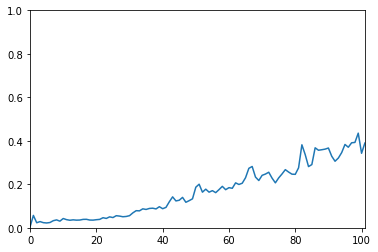

In [6]:
df['iter_time'].plot()
plt.ylim([0, 1])

In [24]:
#df_default = df
#df_opt_noz = df
df_opt_z = df

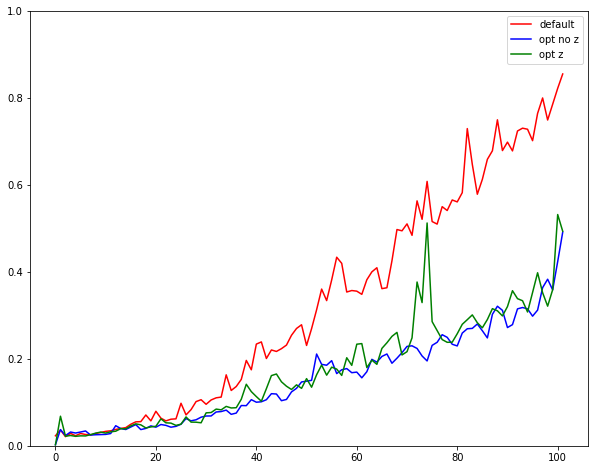

In [27]:
m = 'iter_time' # fscore, iter_time
mask = ~df_default[m].isnull()
idx = df_default.index[mask]
plt.figure(figsize=(10, 8))
plt.plot(idx, df_default[m].loc[mask], c='r', label='default')
plt.plot(idx, df_opt_noz[m].loc[mask], c='b', label='opt no z')
plt.plot(idx, df_opt_z[m].loc[mask], c='g', label='opt z')
plt.ylim([0, 1])
plt.legend(loc='best')
plt.show()

# FACTORIZATION EXAMPLE

In [5]:
# SET-UP EXPLORATION CONFIGURATION
NUMBER_OF_ITERATIONS = 100  # number of points to be labeled by the user
SUBSAMPLING = None
INITIAL_SAMPLER = stratified_sampler(labeled_set, pos=1, neg=1)  # start with one random positive sample and one random negative sample
#INITIAL_SAMPLER = random_sampler(10)
CALLBACK = [ # callback functions to be called at the end of each iteration
    classification_metrics(labeled_set.labels, 'fscore'), 
    three_set_metric,
]
CALLBACK_SKIP = 10
PRINT_CALLBACK_RESULT = True
CONVERGENCE_CRITERIA = [
    max_iter_reached(NUMBER_OF_ITERATIONS),
    #metric_reached_threshold('fscore', 0.8),
    metric_reached_threshold('tsm', 1.0),
]
SEED = None

explore = PoolBasedExploration(INITIAL_SAMPLER, SUBSAMPLING, CALLBACK, CALLBACK_SKIP, PRINT_CALLBACK_RESULT, CONVERGENCE_CRITERIA)

# Factorized AL algorithms
PARTITION = [[i] for i in range(dim)]  #[[0], [1]]

# FACTORIZED VERSION SPACE
# label_function = 'AND', 'OR', 'PROD'
# loss = 'GREEDY', 'SQUARED', 'PRODUCT'
#learner = SubspatialVersionSpace(warmup=100, thin=10, n_samples=8, rounding=True, kernel='rbf', gamma=None, partition=PARTITION, label_function='AND', loss='GREEDY')

# FACTORIZED SIMPLE MARGIN
#learner = SubspatialSimpleMargin(C=1024, kernel='rbf', gamma=5, partition=PARTITION, label_function='AND')

# FACTORIZED DSM
learner = FactorizedDualSpaceModel(SimpleMargin(C=1024, kernel='rbf'), partition=PARTITION, mode='positive', sample_unknown_proba=0.5)  # Dual Space model


# RUN EXPLORATION
metrics = explore.run(X, labeled_set, learner, repeat=1, seed=SEED)  # use y_subspace here

# COMPUTE AVERAGE F-SCORE OVER ALL REPEATS AND PLOT
#plot_fscore(metrics)
df = pd.DataFrame.from_dict({i: metric for i, metric in enumerate(metrics[0])}, orient='index')
df

iter: 1, fscore: 0.002657756853215886, tsm: 0.0
iter: 11, fscore: 0.09317166560306318, tsm: 0.009913258983890954
iter: 21, fscore: 0.5517241379310345, tsm: 0.15873015873015872
iter: 31, fscore: 0.9237668161434978, tsm: 0.7611940298507462
iter: 41, fscore: 0.9952153110047847, tsm: 0.9904761904761905
iter: 51, fscore: 1.0, tsm: 1.0


,phase,iter_time,labeled_indexes,final_labels,partial_labels,fit_time,get_next_time,fscore,tsm,callback_time
0,begin,0.002893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,initial_sampling,0.154974,"[-469100, -110910]","[1.0, 0.0]","[[1.0, 1.0], [0.0, 0.0]]",0.127488,0.027485,0.002658,0.000000,0.436653
2,exploration,0.526766,[-972020],[0.0],"[[0.0, 0.0]]",0.511115,0.015651,NaN,NaN,NaN
3,exploration,0.162357,[-571080],[0.0],"[[0.0, 0.0]]",0.150581,0.011777,NaN,NaN,NaN
4,exploration,0.278140,[-548470],[0.0],"[[0.0, 0.0]]",0.238073,0.040067,NaN,NaN,NaN
5,exploration,0.017036,[-119180],[0.0],"[[0.0, 1.0]]",0.012492,0.004544,NaN,NaN,NaN
6,exploration,0.142017,[-161830],[0.0],"[[0.0, 0.0]]",0.021640,0.120377,NaN,NaN,NaN
7,exploration,0.047173,[-645590],[0.0],"[[0.0, 1.0]]",0.005018,0.042155,NaN,NaN,NaN
8,exploration,0.013786,[-1280],[0.0],"[[0.0, 0.0]]",0.012006,0.001781,NaN,NaN,NaN
9,exploration,0.010827,[-929750],[0.0],"[[0.0, 0.0]]",0.007606,0.003221,NaN,NaN,NaN
